In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

import torch
import torch.autograd as agd
import torch.nn as tchnn
import torch.nn.functional as F
import torch.optim as optim
import random

import os, sys
sys.path.append(os.getcwd())

#to get the MNIST dataset from tf
# import keras
# from keras.datasets import mnist

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#some params
DIM = 512
FIXED_GEN = False
LAMBDA = .1
DISCRI_ITR = 5
BATCHSZ = 256
batchSz = BATCHSZ
TOT_GEN_ITR = 1001#100000

In [3]:
#gaussian mixture dataset creation
class GMMsampler:
    
    def __init__( self, n_samples, n_components=1, weights=[1], mu=[np.array([0,0])], sig=[np.array([[1,0],[0,1]])]):
        self.n_components = n_components
        self.n_samples = n_samples
        self.weights = weights
        self.mu = mu
        self.sig = sig
        self.dim = mu[0].size
        self.data = np.empty([n_samples, self.dim])
        self.datacid = dict()
        
    def check_musig(self):
        shmu = self.mu[0].shape
        shsig = self.sig[0].shape
        if(not(all(m.shape==shmu for m in mu))):
            print('all mean vectors must be of same dimension')
        if(not(all(s.shape==shmu for s in sig))):
            print('all covariance matrix must be of same dimension')
    
    def gen_sample(self):
        for i in range(self.n_components):
            self.datacid[i] = []
        for i in range(self.n_samples):
            idx = np.random.choice(np.arange(0,self.n_components), p=(self.weights)/np.sum(self.weights))
            mu_,sig_ = self.mu[idx], self.sig[idx]
            self.data[i,:] = np.random.multivariate_normal(mu_, sig_)
            self.datacid[idx].append(self.data[i,:])
        for idx in range(self.n_components):
            self.datacid[idx] = np.array(self.datacid[idx]).reshape(-1,2)
            
    def plot_centers(self):
        plt.figure()
        for c in self.mu:
            plt.scatter(c[0], c[1])
        plt.show()
        
    def plot_data(self):
        plt.figure()
        for i in range(self.n_components):
            plt.scatter(self.datacid[i][:,0], self.datacid[i][:,1])
        plt.show()

scale = 2
m1 = np.array([-1, 0])*scale
m2 = np.array([1, 0])*scale
m3 = np.array([0, 1])*scale
m4 = np.array([0, -1])*scale
m5 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])*scale
m6 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])*scale
m7 = np.array([-1/np.sqrt(2), 1/np.sqrt(2)])*scale
m8 = np.array([-1/np.sqrt(2), -1/np.sqrt(2)])*scale

sig1 = np.eye(2)/1.414
sig2 = np.eye(2)/1.414
sig3 = np.eye(2)/1.414
sig4 = np.eye(2)/1.414
sig5 = np.eye(2)/1.414
sig6 = np.eye(2)/1.414
sig7 = np.eye(2)/1.414
sig8 = np.eye(2)/1.414

In [4]:
#models of generator and discriminator
class Generator(tchnn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.L1 = tchnn.Linear(2, DIM)
        self.L2 = tchnn.Linear(DIM, DIM)
        self.L3 = tchnn.Linear(DIM, DIM)
        self.Ou = tchnn.Linear(DIM,2)
    def forward(self, noise, real_data):
        if FIXED_GEN:
            return noise + real_data
        else:
            x = F.relu(self.L1(noise))
            x = F.relu(self.L2(x))
            x = F.relu(self.L3(x))
            x = self.Ou(x)
            return x.view(-1,2)
    def name(self):
        return 'GENERATOR'

In [5]:
class Discriminator(tchnn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.L1 = tchnn.Linear(2, DIM)
        self.L2 = tchnn.Linear(DIM, DIM)
        self.L3 = tchnn.Linear(DIM, DIM)
        self.Ou = tchnn.Linear(DIM,1)
    def forward(self, x):
            x = F.relu(self.L1(x))
            x = F.relu(self.L2(x))
            x = F.relu(self.L3(x))
            x = self.Ou(x)
            return x.view(-1)
    def name(self):
        return 'DISCRIMINATOR'

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
#training data generator
def traindata_gen():
    g = GMMsampler(batchSz, n_components=8, weights=[1, 1, 1, 1, 1, 1, 1, 1],
                  mu=[m1,m2,m3,m4,m5,m6,m7,m8], sig=[sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8])
    while(True):
        g.gen_sample()
        #g.plot_centers()
        #g.plot_data()
        yield g.data
d = traindata_gen()

In [8]:
#gradient penalty term in objective
def calc_gp(D, real_data, fake_data):
    α = torch.rand(BATCHSZ, 1)
    α = α.expand(real_data.size())
    α = α.cuda()
    
    interpolated = α*real_data + (1-α)*fake_data
    interpolated = interpolated.cuda()
    interpolated = agd.Variable(interpolated, requires_grad=True)
    
    D_interp = D(interpolated)
    
    gradients = agd.grad(outputs=D_interp, inputs=interpolated, grad_outputs=torch.ones(D_interp.size()).cuda()
                        ,create_graph=True, retain_graph=True, only_inputs=True)[0]
    gp = ((gradients.norm(2, dim=1) - 1)**2).mean()*LAMBDA
    return gp

In [9]:
#notaion similar to paper
G = Generator().cuda()
D = Discriminator().cuda()
G.apply(weights_init)
D.apply(weights_init)
print(G)
print(D)

Generator (
  (L1): Linear (2 -> 512)
  (L2): Linear (512 -> 512)
  (L3): Linear (512 -> 512)
  (Ou): Linear (512 -> 2)
)
Discriminator (
  (L1): Linear (2 -> 512)
  (L2): Linear (512 -> 512)
  (L3): Linear (512 -> 512)
  (Ou): Linear (512 -> 1)
)


In [10]:
optD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))
optG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [11]:
one = torch.FloatTensor([1])
onebar = one * -1
one = one.cuda()
onebar = onebar.cuda()

In [12]:
#to plot results
def generate_image(true_dist):
    """
    Generates and saves a plot of the true distribution, the generator, and the
    critic.
    """
    N_POINTS = 128
    RANGE = 3

    points = np.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:, :, 0] = np.linspace(-RANGE, RANGE, N_POINTS)[:, None]
    points[:, :, 1] = np.linspace(-RANGE, RANGE, N_POINTS)[None, :]
    points = points.reshape((-1, 2))

    points_v = agd.Variable(torch.Tensor(points), volatile=True).cuda()
    disc_map = D(points_v).cpu().data.numpy()

    noise = torch.randn(BATCHSZ, 2).cuda()
    
    noisev = agd.Variable(noise, volatile=True)
    
    true_dist_v = agd.Variable(torch.Tensor(true_dist).cuda())
    
    samples = G(noisev, true_dist_v).cpu().data.numpy()

    plt.clf()

    x = y = np.linspace(-RANGE, RANGE, N_POINTS)
    plt.contour(x, y, disc_map.reshape((len(x), len(y))).transpose())

    plt.scatter(true_dist[:, 0], true_dist[:, 1], c='orange', marker='+')
    if not FIXED_GEN:
        plt.scatter(samples[:, 0], samples[:, 1], c='green', marker='+')
    print('showing a graph')
    plt.show()

The GAN has 2 networks D and G, the training is done as follows,  the discriminator is trained first on the real data-set and then on the fake dataset, this would obviously mean that there will be backpropgation in the discriminator network, however when I'm training the generator I don't want the weights of the discriminators to change because the discrimantor will always adapt itself to tell generator is giving out fake and poor generator will never be able to catch up with D, hence when the generator is training discriminator is freezed

In [13]:
## dont touch unless you want to train
for itr in range(TOT_GEN_ITR):
    ## D training and hence layers paprams should get updated.
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(DISCRI_ITR):
        #print(iter_d)
        _data = next(d)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)
        #print(real_data_v)

        D.zero_grad()

        # train with real
        D_real = D(real_data_v)
        D_real = D_real.mean() + D_real.std()
        D_real.backward(onebar)

        # train with fake
        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise, volatile=True)  # totally freeze netG
        
        #noisev = agd.Variable(noise)
        gop = G(noisev, real_data_v)
        #print('here3')
        fake = agd.Variable(gop.data)
        inputv = fake
        D_fake = D(inputv)
        D_fake = D_fake.mean() + D_fake.std()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gp(D, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optD.step()
        #print('discri iter done ', iter_d)

    if not FIXED_GEN:
        #now the discriminator should not be updating it's weights
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()

        _data = next(d)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)

        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise)
        fake = G(noisev, real_data_v)
        g_ = D(fake)
        g_ = g_.mean()
        g_.backward(onebar)
        G_cost = -g_
        optG.step()
    print('itr: {} done'.format(itr))
    # Write logs and save samples
    #lib.plot.plot('tmp/' + DATASET + '/' + 'disc cost', D_cost.cpu().data.numpy())
    #lib.plot.plot('tmp/' + DATASET + '/' + 'wasserstein distance', Wasserstein_D.cpu().data.numpy())
    if not FIXED_GEN:
        #lib.plot.plot('tmp/' + DATASET + '/' + 'gen cost', G_cost.cpu().data.numpy())
        if itr % 100 == 99:
        #lib.plot.flush()
            generate_image(_data)
        #lib.plot.tick()

itr: 0 done
itr: 1 done
itr: 2 done
itr: 3 done
itr: 4 done
itr: 5 done
itr: 6 done
itr: 7 done
itr: 8 done
itr: 9 done
itr: 10 done
itr: 11 done
itr: 12 done
itr: 13 done
itr: 14 done
itr: 15 done
itr: 16 done
itr: 17 done
itr: 18 done
itr: 19 done
itr: 20 done


KeyboardInterrupt: 

## testing on the far away, differently oriented gaussians (triplets)

In [14]:
def triplegauss_gen():
    c1 = np.array([0,0])*2
    c2 = np.array([5,5])*2
    c3 = np.array([7,-14])*2
    s1 = np.array([[1,0],[0,6]])
    s2 = np.array([[6,0],[0,2]])
    s3 = np.array([[2,10],[7,6]])
    g = GMMsampler(batchSz, n_components=3, weights=[1, 1, 1],
                  mu=[c1,c2,c3], sig=[s1,s2,s3])
    while(True):
        g.gen_sample()
#         g.plot_centers()
#         g.plot_data()
        yield g.data
dtriple = triplegauss_gen()

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


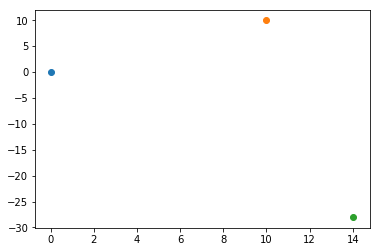

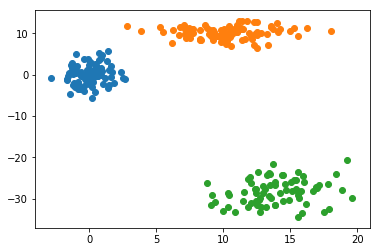

array([[  1.23813583e+01,  -2.75770742e+01],
       [ -1.22934859e+00,   1.48561089e+00],
       [  1.30061946e+01,  -2.68174949e+01],
       [  2.10909694e-01,   9.09969484e-01],
       [  1.05980491e+01,   6.82722279e+00],
       [  5.25213767e+00,   1.16219661e+01],
       [ -3.95222094e-01,  -2.61788327e+00],
       [ -1.07737960e+00,  -3.00426979e+00],
       [  1.54516268e+01,  -2.76043314e+01],
       [  1.43549668e+00,   5.80073627e+00],
       [  1.58999829e+01,  -3.33771803e+01],
       [  9.11078099e+00,   9.23564266e+00],
       [  2.34609469e+00,   6.00161535e-01],
       [  1.51954612e+00,  -2.56652616e+00],
       [  8.86264571e-01,   1.57494066e+00],
       [  1.33901574e+01,  -2.37243094e+01],
       [  1.18688017e+01,  -2.51971163e+01],
       [  1.01965403e+01,   7.43756402e+00],
       [ -2.60869735e-01,  -3.70968826e-01],
       [  1.57791245e+01,  -2.80496555e+01],
       [  1.36835530e+01,   1.11229719e+01],
       [  8.78550403e+00,   1.11923616e+01],
       [  

In [53]:
next(dtriple)

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


itr: 0 done
itr: 50 done
showing a graph


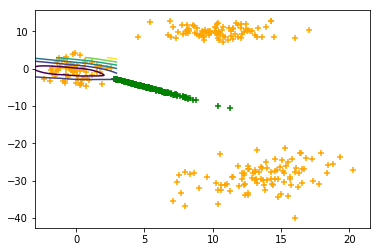

itr: 100 done
itr: 150 done
showing a graph


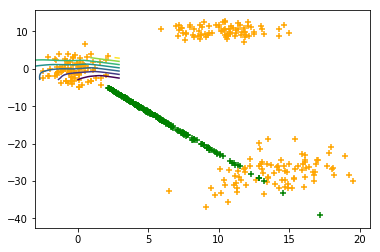

itr: 200 done
itr: 250 done
showing a graph


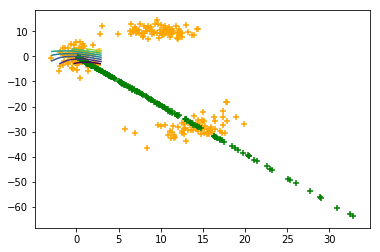

itr: 300 done
itr: 350 done
showing a graph


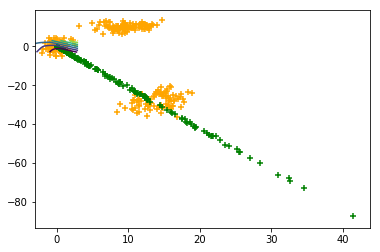

itr: 400 done
itr: 450 done
showing a graph


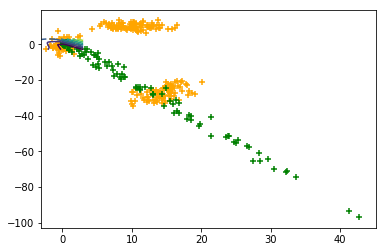

itr: 500 done
itr: 550 done
showing a graph


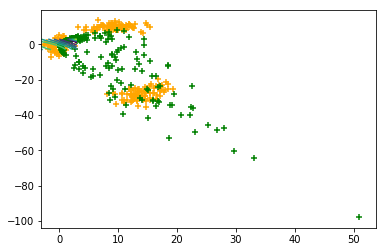

itr: 600 done
itr: 650 done
showing a graph


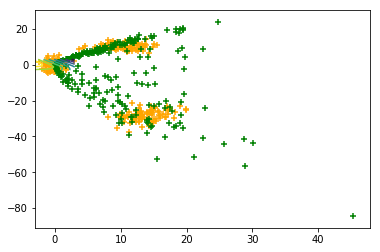

itr: 700 done
itr: 750 done
showing a graph


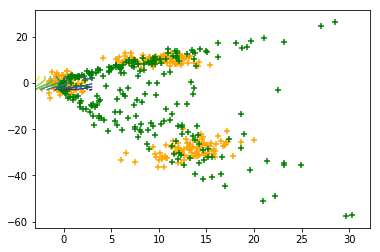

itr: 800 done
itr: 850 done
showing a graph


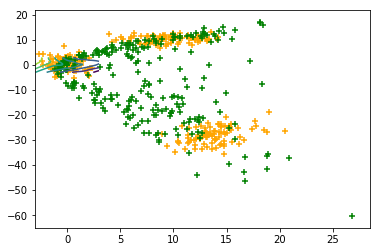

itr: 900 done
itr: 950 done
showing a graph


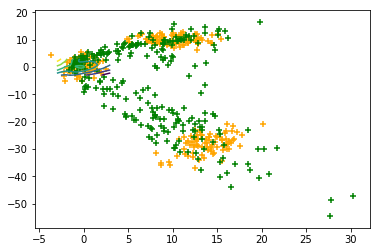

itr: 1000 done
itr: 1050 done
showing a graph


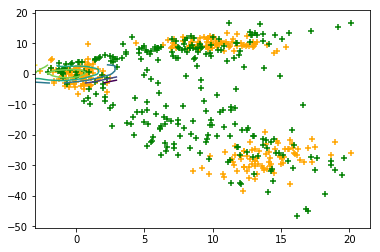

itr: 1100 done
itr: 1150 done
showing a graph


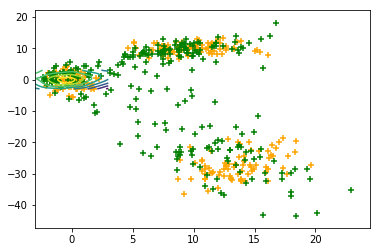

itr: 1200 done
itr: 1250 done
showing a graph


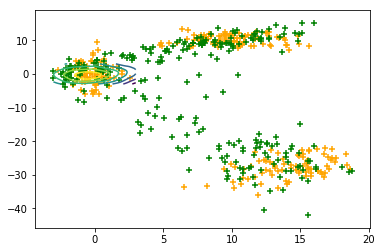

itr: 1300 done
itr: 1350 done
showing a graph


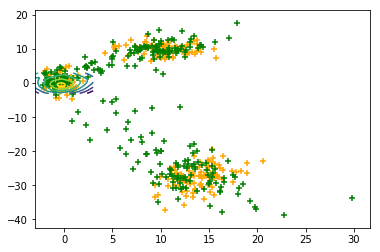

itr: 1400 done
itr: 1450 done
showing a graph


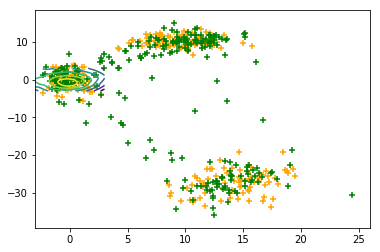

itr: 1500 done
itr: 1550 done
showing a graph


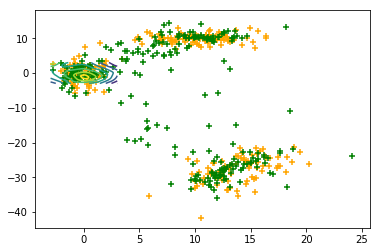

itr: 1600 done
itr: 1650 done
showing a graph


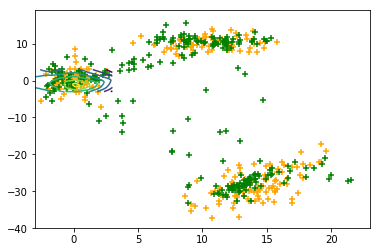

itr: 1700 done
itr: 1750 done
showing a graph


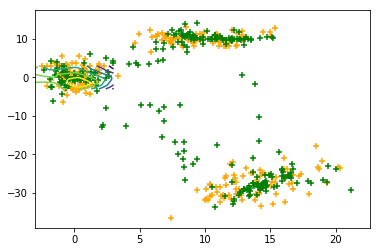

itr: 1800 done
itr: 1850 done
showing a graph


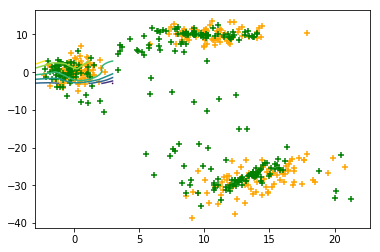

itr: 1900 done
itr: 1950 done
showing a graph


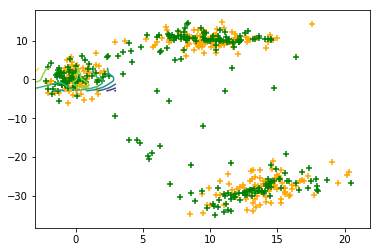

itr: 2000 done
itr: 2050 done
showing a graph


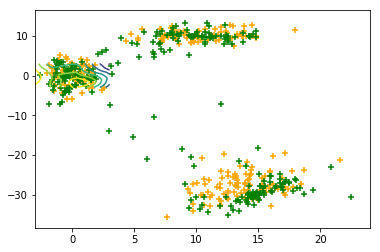

itr: 2100 done
itr: 2150 done
showing a graph


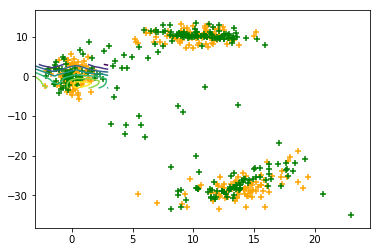

itr: 2200 done
itr: 2250 done
showing a graph


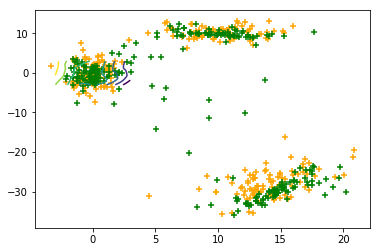

itr: 2300 done
itr: 2350 done
showing a graph


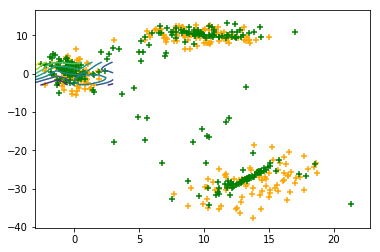

itr: 2400 done
itr: 2450 done
showing a graph


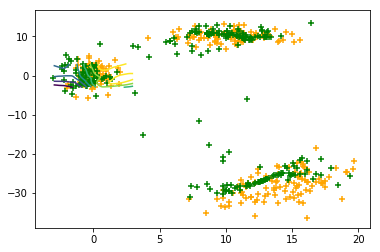

itr: 2500 done
itr: 2550 done
showing a graph


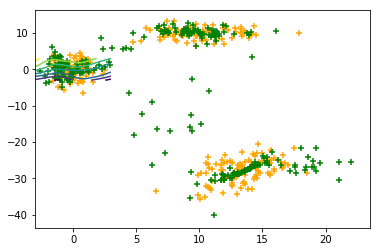

itr: 2600 done
itr: 2650 done
showing a graph


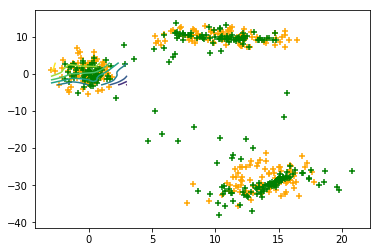

itr: 2700 done
itr: 2750 done
showing a graph


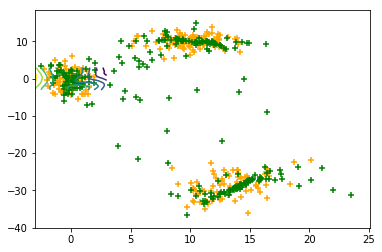

itr: 2800 done
itr: 2850 done
showing a graph


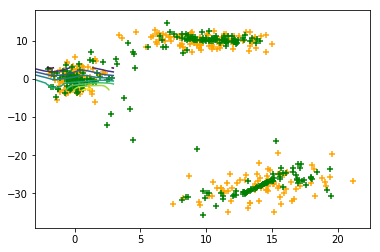

itr: 2900 done
itr: 2950 done
showing a graph


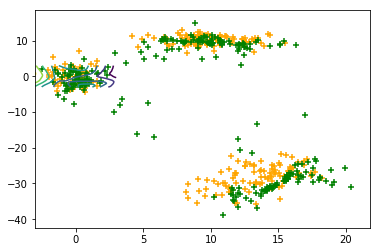

itr: 3000 done
itr: 3050 done
showing a graph


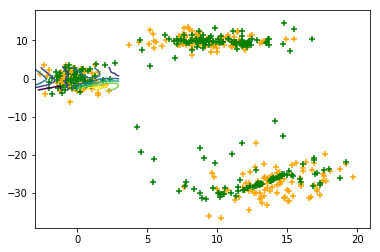

itr: 3100 done
itr: 3150 done
showing a graph


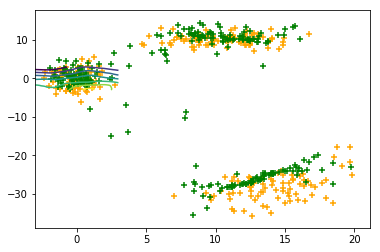

itr: 3200 done
itr: 3250 done
showing a graph


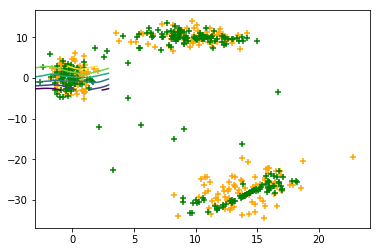

itr: 3300 done
itr: 3350 done
showing a graph


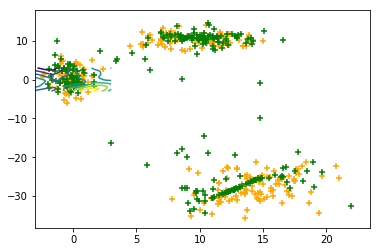

itr: 3400 done
itr: 3450 done
showing a graph


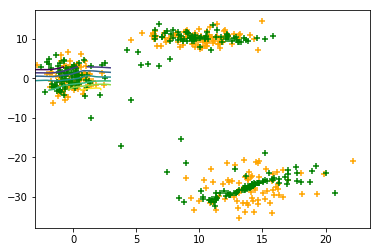

itr: 3500 done
itr: 3550 done
showing a graph


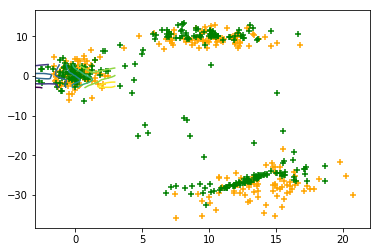

itr: 3600 done
itr: 3650 done
showing a graph


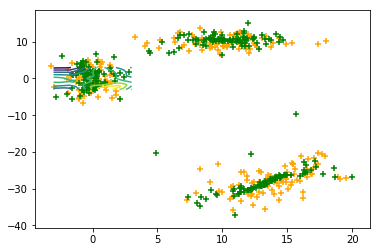

itr: 3700 done
itr: 3750 done
showing a graph


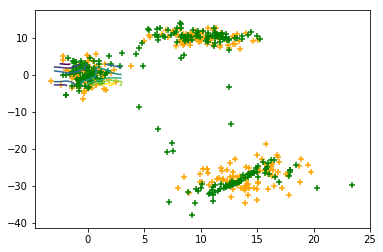

itr: 3800 done
itr: 3850 done
showing a graph


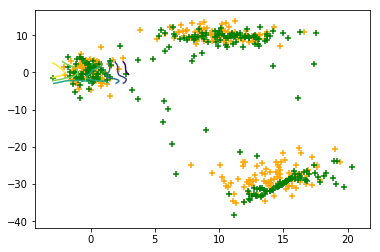

itr: 3900 done
itr: 3950 done
showing a graph


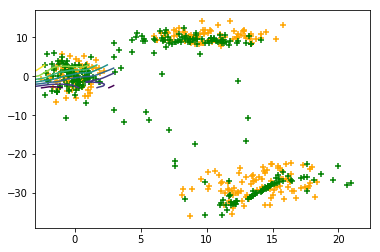

itr: 4000 done
itr: 4050 done
showing a graph


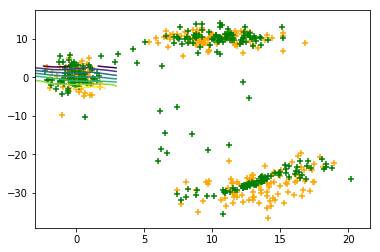

itr: 4100 done
itr: 4150 done
showing a graph


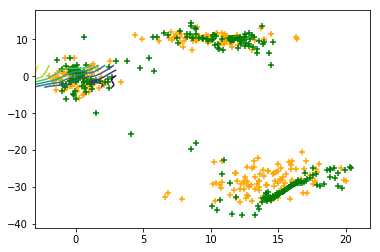

itr: 4200 done
itr: 4250 done
showing a graph


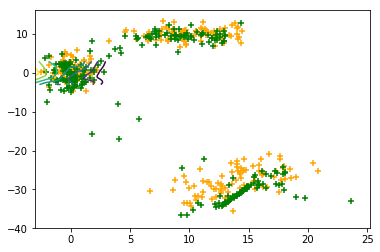

itr: 4300 done
itr: 4350 done
showing a graph


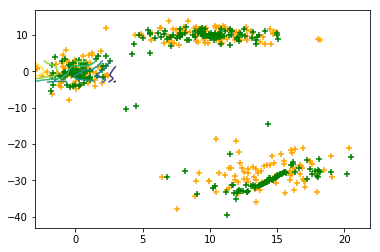

itr: 4400 done
itr: 4450 done
showing a graph


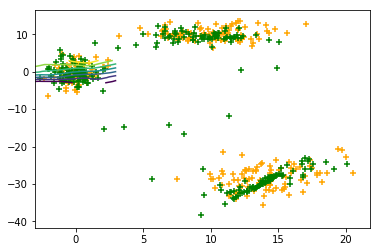

itr: 4500 done
itr: 4550 done
showing a graph


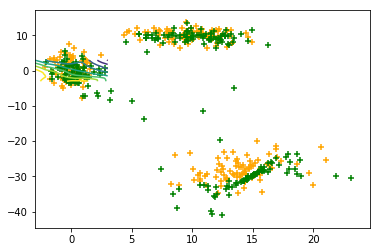

itr: 4600 done
itr: 4650 done
showing a graph


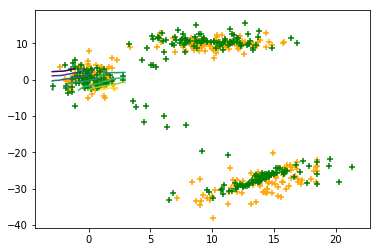

itr: 4700 done
itr: 4750 done
showing a graph


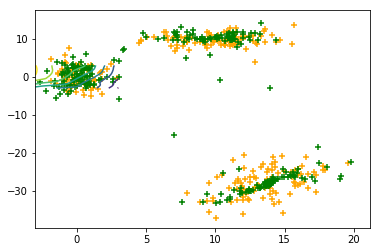

itr: 4800 done
itr: 4850 done
showing a graph


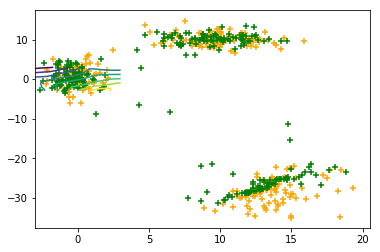

itr: 4900 done
itr: 4950 done
showing a graph


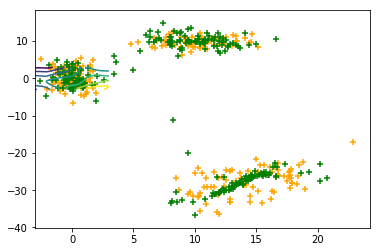

itr: 5000 done
itr: 5050 done
showing a graph


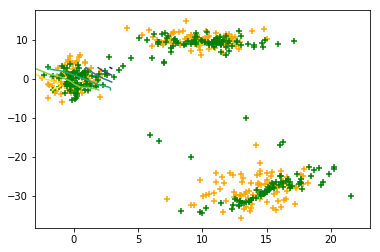

itr: 5100 done
itr: 5150 done
showing a graph


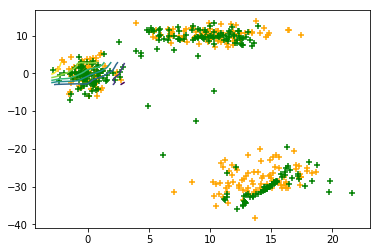

itr: 5200 done
itr: 5250 done
showing a graph


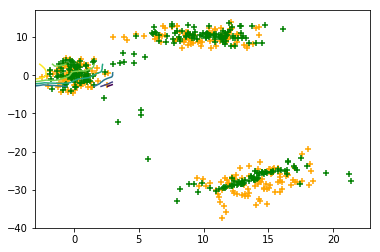

itr: 5300 done
itr: 5350 done
showing a graph


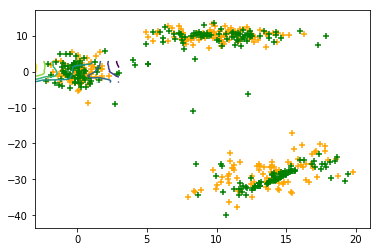

itr: 5400 done
itr: 5450 done
showing a graph


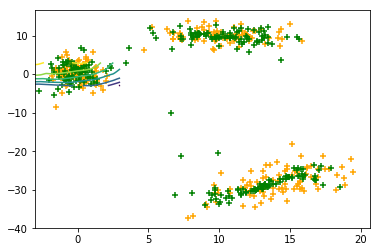

itr: 5500 done
itr: 5550 done
showing a graph


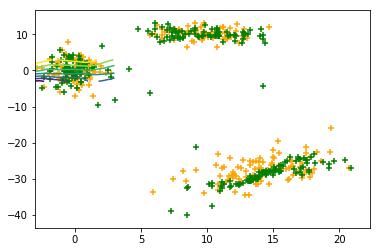

itr: 5600 done
itr: 5650 done
showing a graph


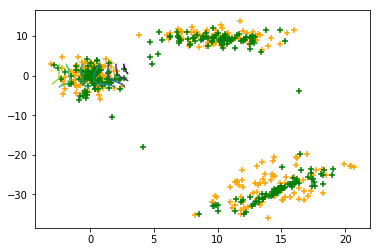

itr: 5700 done
itr: 5750 done
showing a graph


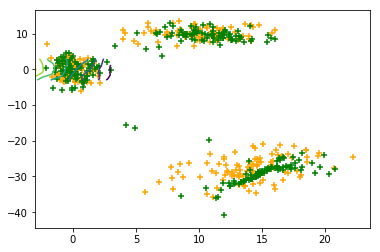

itr: 5800 done
itr: 5850 done
showing a graph


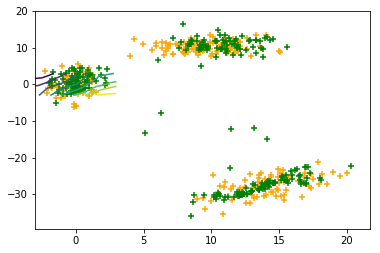

itr: 5900 done
itr: 5950 done
showing a graph


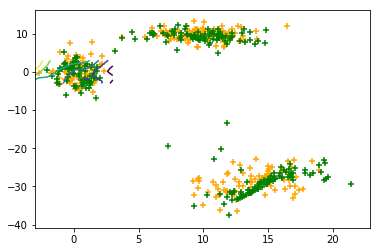

itr: 6000 done
itr: 6050 done
showing a graph


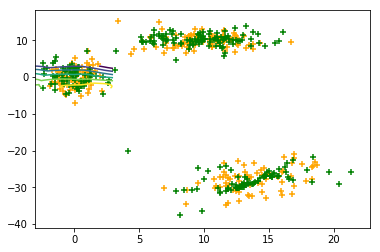

itr: 6100 done
itr: 6150 done
showing a graph


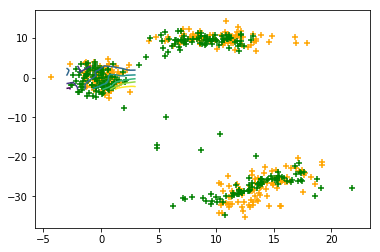

itr: 6200 done
itr: 6250 done
showing a graph


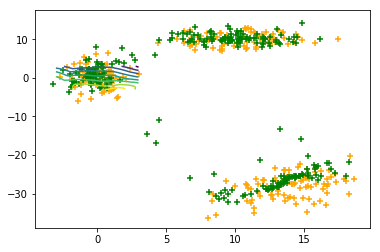

itr: 6300 done
itr: 6350 done
showing a graph


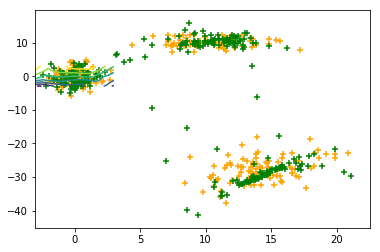

itr: 6400 done
itr: 6450 done
showing a graph


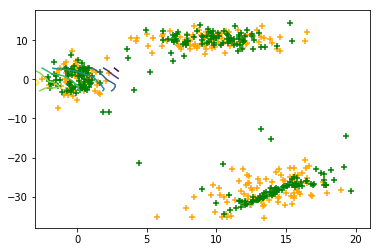

itr: 6500 done
itr: 6550 done
showing a graph


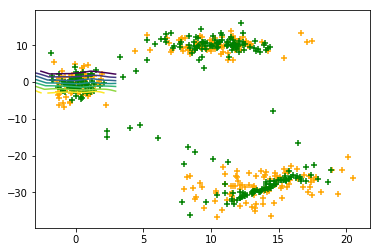

itr: 6600 done
itr: 6650 done
showing a graph


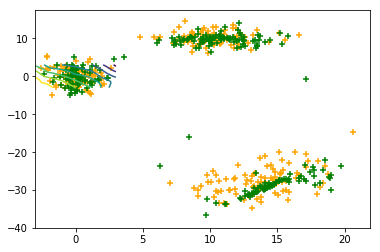

itr: 6700 done
itr: 6750 done
showing a graph


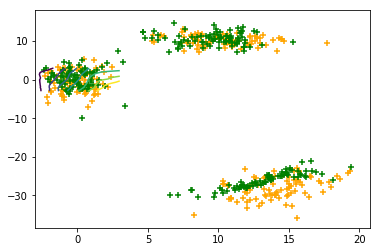

itr: 6800 done
itr: 6850 done
showing a graph


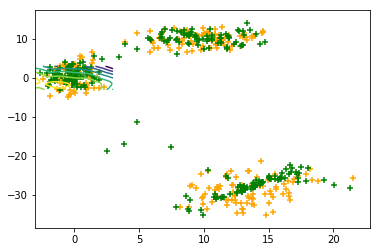

itr: 6900 done
itr: 6950 done
showing a graph


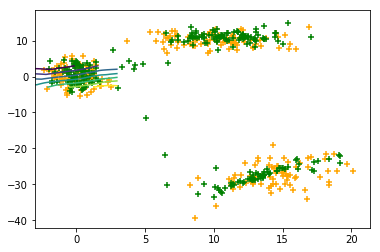

itr: 7000 done
itr: 7050 done
showing a graph


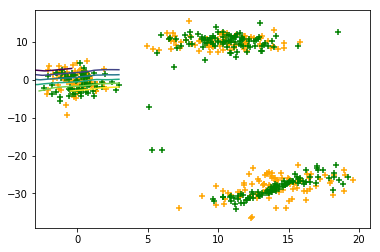

itr: 7100 done
itr: 7150 done
showing a graph


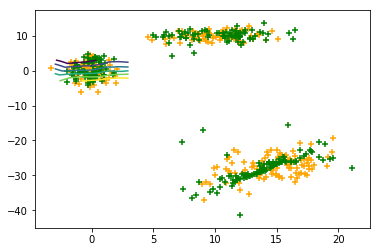

itr: 7200 done
itr: 7250 done
showing a graph


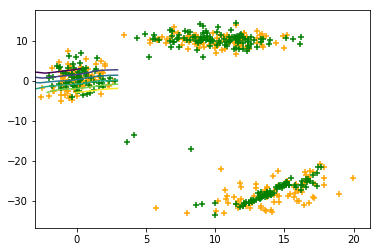

itr: 7300 done
itr: 7350 done
showing a graph


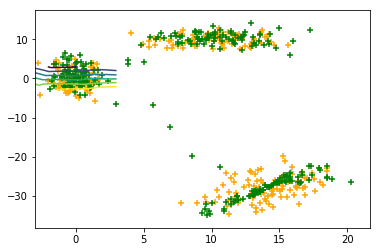

itr: 7400 done
itr: 7450 done
showing a graph


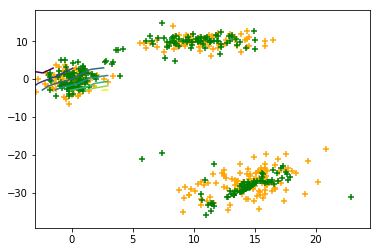

itr: 7500 done
itr: 7550 done
showing a graph


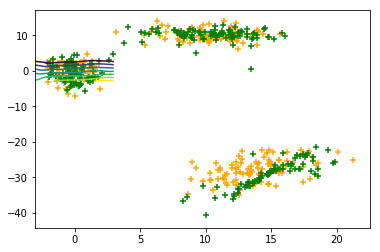

itr: 7600 done
itr: 7650 done
showing a graph


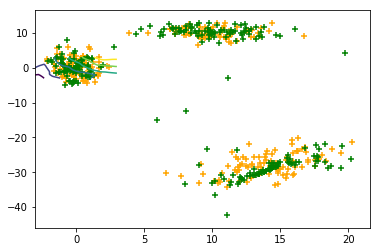

itr: 7700 done
itr: 7750 done
showing a graph


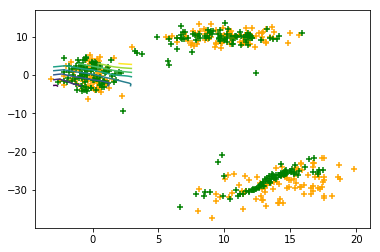

itr: 7800 done
itr: 7850 done
showing a graph


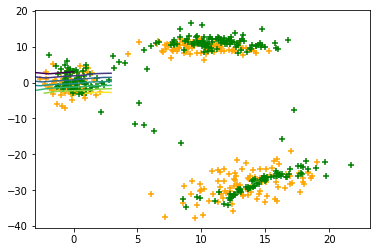

itr: 7900 done
itr: 7950 done
showing a graph


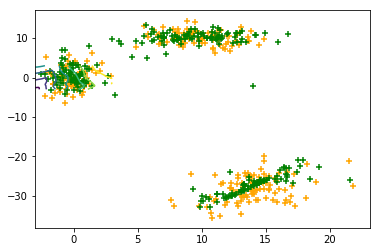

itr: 8000 done
itr: 8050 done
showing a graph


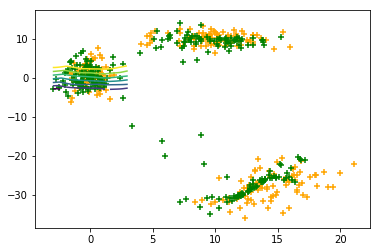

itr: 8100 done
itr: 8150 done
showing a graph


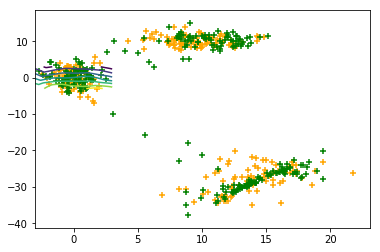

itr: 8200 done
itr: 8250 done
showing a graph


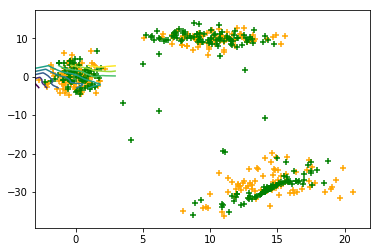

itr: 8300 done
itr: 8350 done
showing a graph


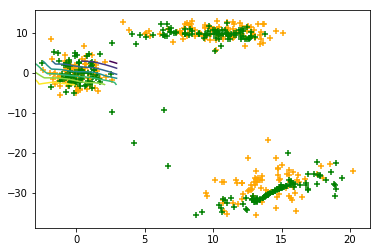

itr: 8400 done
itr: 8450 done
showing a graph


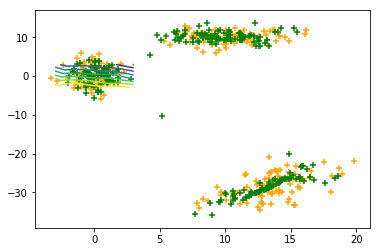

itr: 8500 done
itr: 8550 done
showing a graph


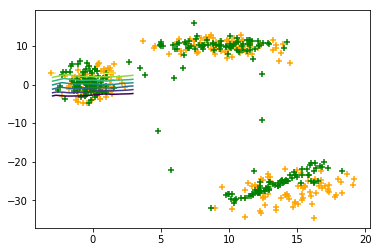

itr: 8600 done
itr: 8650 done
showing a graph


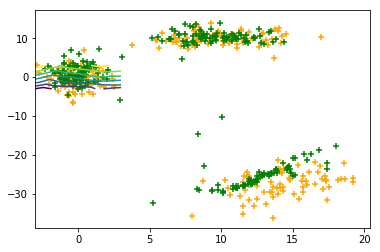

itr: 8700 done
itr: 8750 done
showing a graph


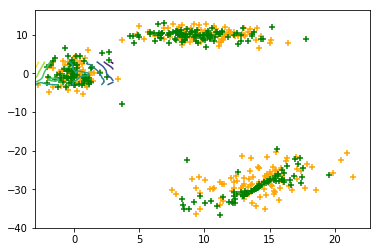

itr: 8800 done
itr: 8850 done
showing a graph


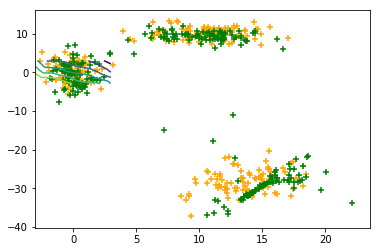

itr: 8900 done
itr: 8950 done
showing a graph


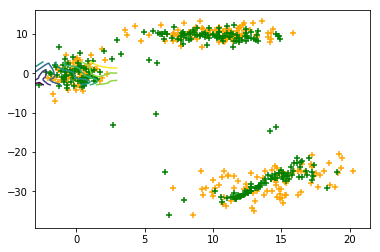

itr: 9000 done
itr: 9050 done
showing a graph


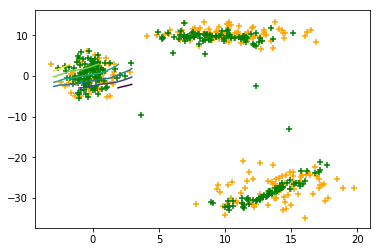

itr: 9100 done
itr: 9150 done
showing a graph


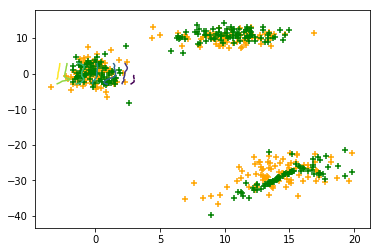

itr: 9200 done
itr: 9250 done
showing a graph


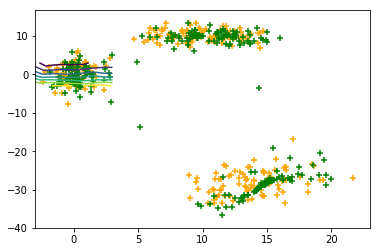

itr: 9300 done
itr: 9350 done
showing a graph


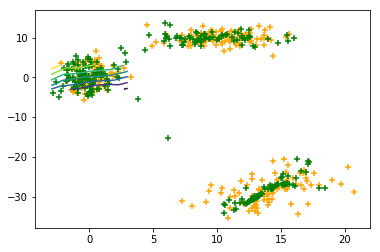

itr: 9400 done
itr: 9450 done
showing a graph


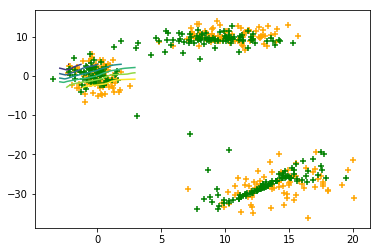

itr: 9500 done
itr: 9550 done
showing a graph


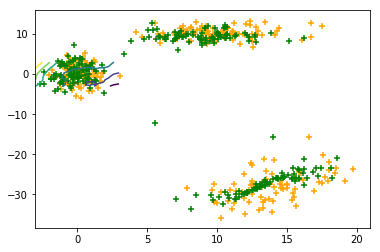

itr: 9600 done
itr: 9650 done
showing a graph


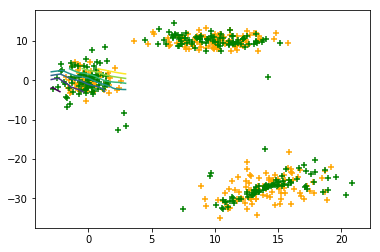

itr: 9700 done
itr: 9750 done
showing a graph


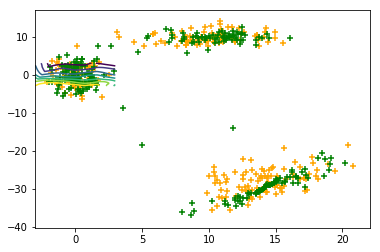

itr: 9800 done
itr: 9850 done
showing a graph


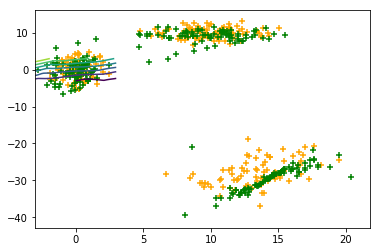

itr: 9900 done
itr: 9950 done
showing a graph


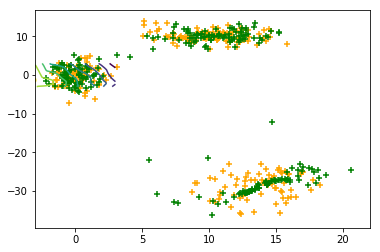

In [13]:
## dont touch unless you want to train
for itr in range(10000):
    ## D training and hence layers paprams should get updated.
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(DISCRI_ITR):
        #print(iter_d)
        _data = next(dtriple)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)
        #print(real_data_v)

        D.zero_grad()

        # train with real
        D_real = D(real_data_v)
        D_real = D_real.mean()
        D_real.backward(onebar)

        # train with fake
        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise, volatile=True)  # totally freeze netG
        
        #noisev = agd.Variable(noise)
        gop = G(noisev, real_data_v)
        #print('here3')
        fake = agd.Variable(gop.data)
        inputv = fake
        D_fake = D(inputv)
        D_fake = D_fake.mean()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gp(D, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optD.step()
        #print('discri iter done ', iter_d)

    if not FIXED_GEN:
        #now the discriminator should not be updating it's weights
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()

        _data = next(dtriple)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)

        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise)
        fake = G(noisev, real_data_v)
        g_ = D(fake)
        g_ = g_.mean()
        g_.backward(onebar)
        G_cost = -g_
        optG.step()
    if itr%50 == 0:
        print('itr: {} done'.format(itr))
    # Write logs and save samples
    #lib.plot.plot('tmp/' + DATASET + '/' + 'disc cost', D_cost.cpu().data.numpy())
    #lib.plot.plot('tmp/' + DATASET + '/' + 'wasserstein distance', Wasserstein_D.cpu().data.numpy())
    if not FIXED_GEN:
        #lib.plot.plot('tmp/' + DATASET + '/' + 'gen cost', G_cost.cpu().data.numpy())
        if itr % 100 == 99:
        #lib.plot.flush()
            generate_image(_data)
        #lib.plot.tick()

/home/udion/Misc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


itr: 0 done
itr: 50 done
showing a graph


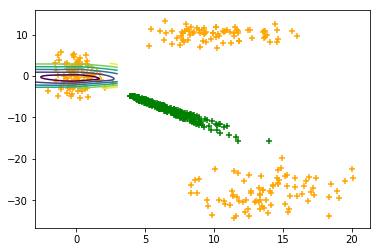

itr: 100 done
itr: 150 done
showing a graph


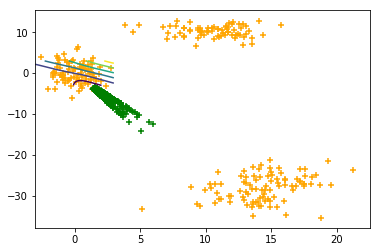

itr: 200 done
itr: 250 done
showing a graph


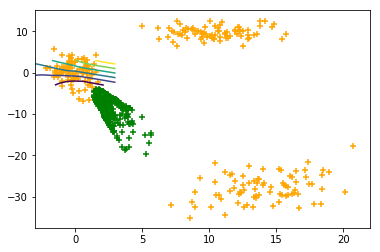

itr: 300 done
itr: 350 done
showing a graph


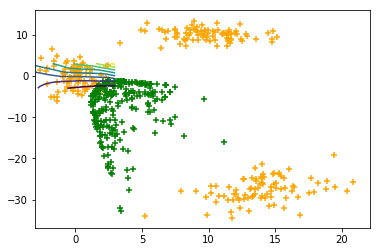

itr: 400 done
itr: 450 done
showing a graph


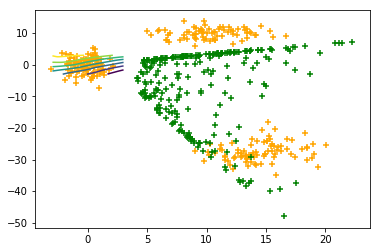

itr: 500 done
itr: 550 done
showing a graph


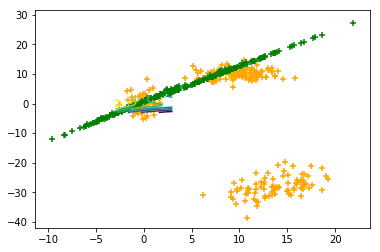

itr: 600 done
itr: 650 done
showing a graph


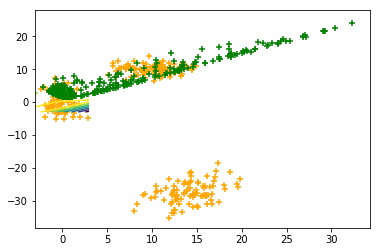

itr: 700 done
itr: 750 done
showing a graph


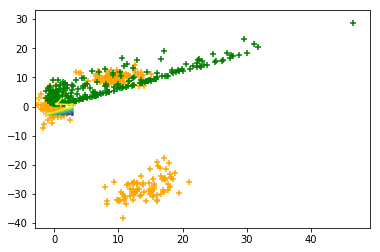

itr: 800 done
itr: 850 done
showing a graph


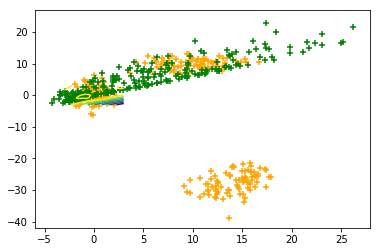

itr: 900 done
itr: 950 done
showing a graph


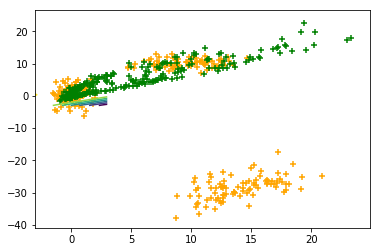

itr: 1000 done
itr: 1050 done
showing a graph


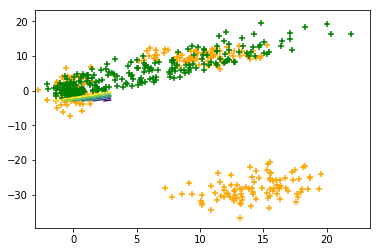

itr: 1100 done
itr: 1150 done
showing a graph


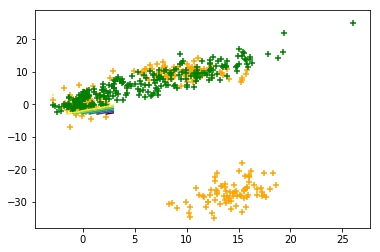

itr: 1200 done
itr: 1250 done
showing a graph


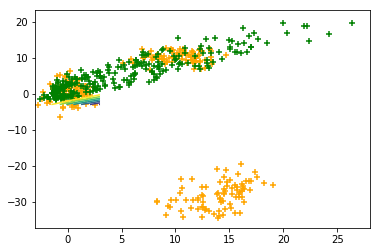

itr: 1300 done
itr: 1350 done
showing a graph


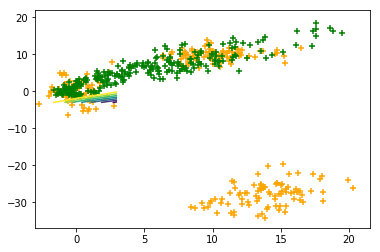

itr: 1400 done
itr: 1450 done
showing a graph


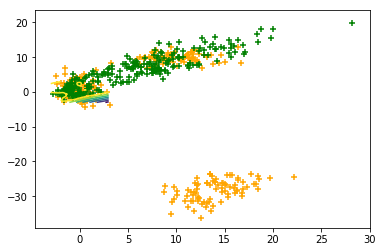

itr: 1500 done
itr: 1550 done
showing a graph


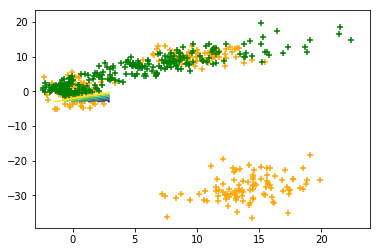

itr: 1600 done
itr: 1650 done
showing a graph


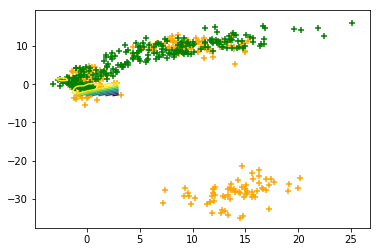

itr: 1700 done
itr: 1750 done
showing a graph


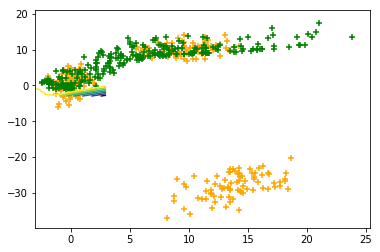

itr: 1800 done
itr: 1850 done
showing a graph


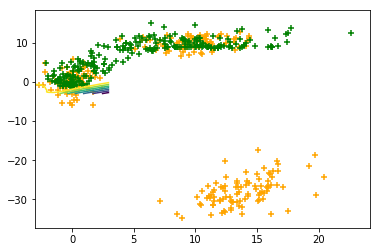

itr: 1900 done
itr: 1950 done
showing a graph


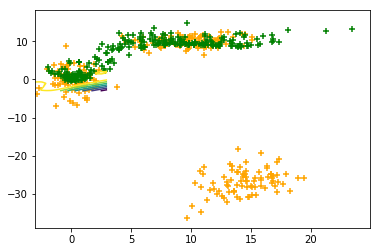

itr: 2000 done
itr: 2050 done
showing a graph


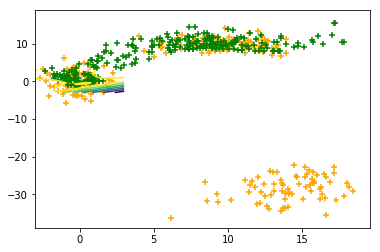

itr: 2100 done
itr: 2150 done
showing a graph


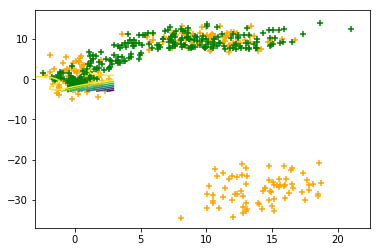

itr: 2200 done
itr: 2250 done
showing a graph


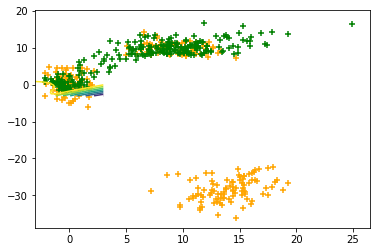

itr: 2300 done
itr: 2350 done
showing a graph


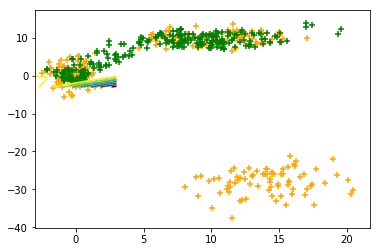

itr: 2400 done
itr: 2450 done
showing a graph


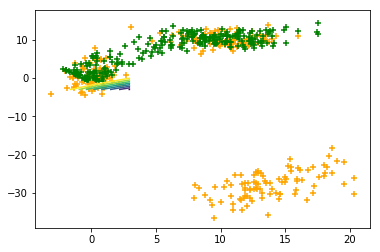

itr: 2500 done
itr: 2550 done
showing a graph


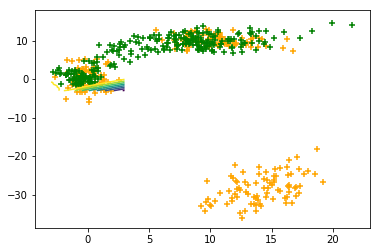

itr: 2600 done
itr: 2650 done
showing a graph


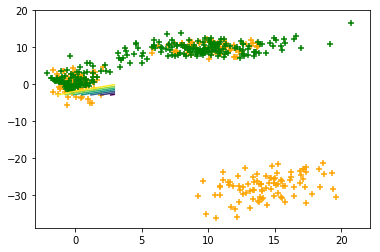

itr: 2700 done
itr: 2750 done
showing a graph


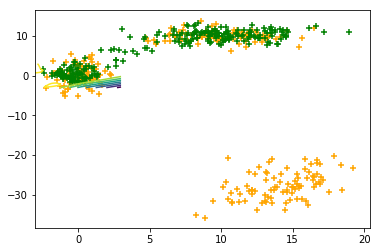

itr: 2800 done
itr: 2850 done
showing a graph


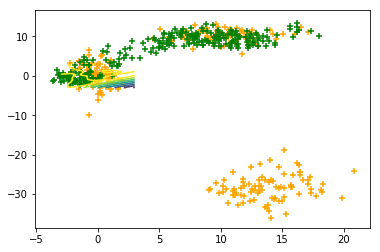

itr: 2900 done
itr: 2950 done
showing a graph


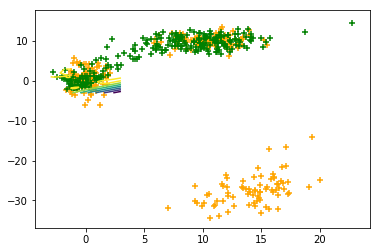

itr: 3000 done
itr: 3050 done
showing a graph


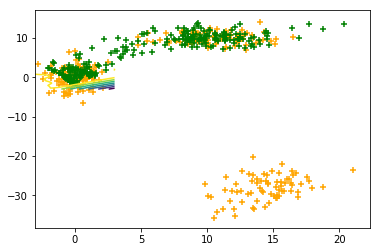

itr: 3100 done
itr: 3150 done
showing a graph


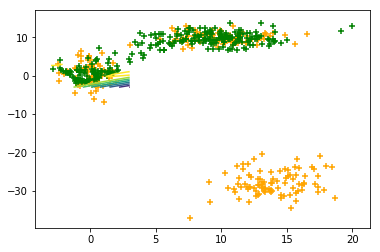

itr: 3200 done
itr: 3250 done
showing a graph


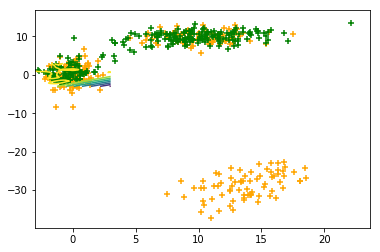

itr: 3300 done
itr: 3350 done
showing a graph


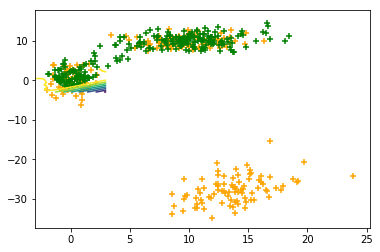

itr: 3400 done
itr: 3450 done
showing a graph


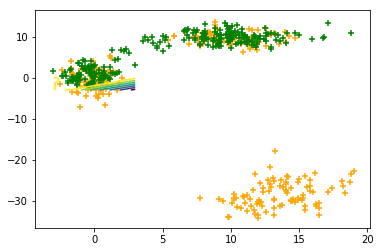

itr: 3500 done
itr: 3550 done
showing a graph


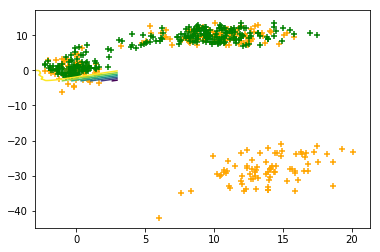

itr: 3600 done
itr: 3650 done
showing a graph


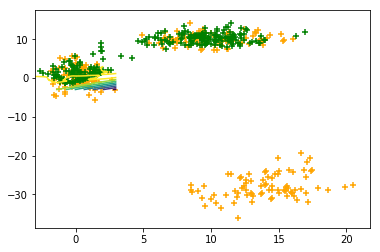

itr: 3700 done
itr: 3750 done
showing a graph


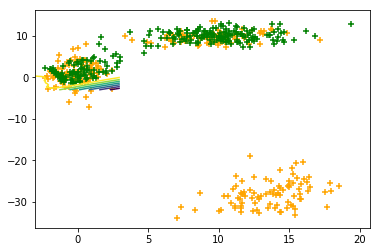

itr: 3800 done
itr: 3850 done
showing a graph


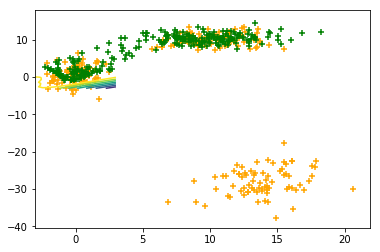

itr: 3900 done
itr: 3950 done
showing a graph


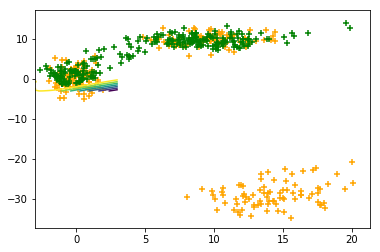

itr: 4000 done
itr: 4050 done
showing a graph


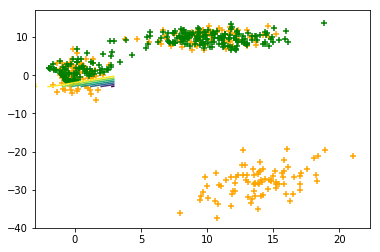

itr: 4100 done
itr: 4150 done
showing a graph


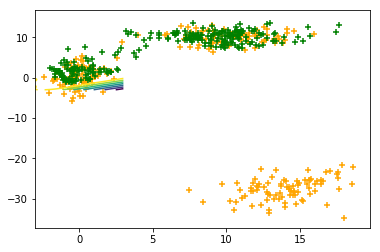

itr: 4200 done
itr: 4250 done
showing a graph


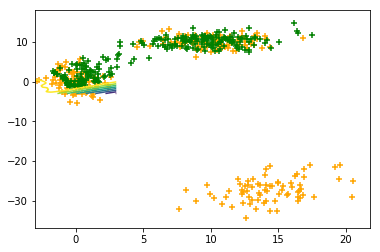

itr: 4300 done
itr: 4350 done
showing a graph


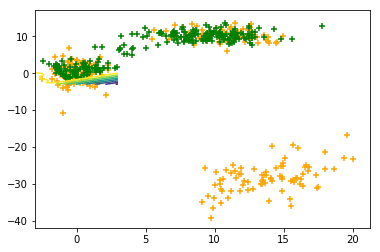

itr: 4400 done
itr: 4450 done
showing a graph


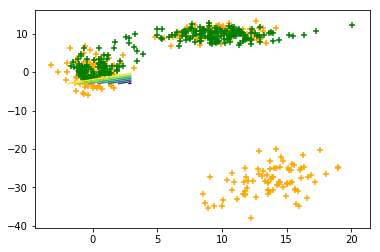

itr: 4500 done
itr: 4550 done
showing a graph


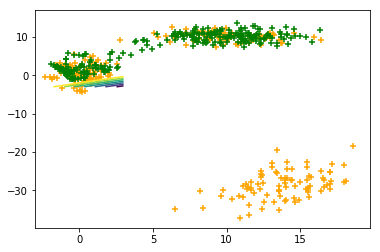

itr: 4600 done
itr: 4650 done
showing a graph


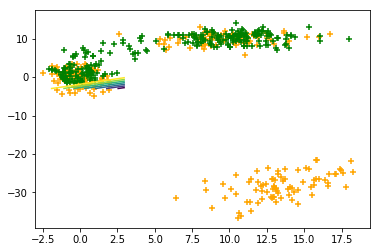

itr: 4700 done
itr: 4750 done
showing a graph


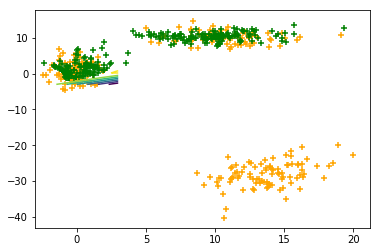

itr: 4800 done
itr: 4850 done
showing a graph


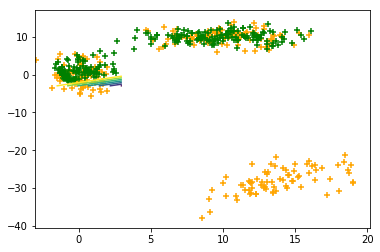

itr: 4900 done
itr: 4950 done
showing a graph


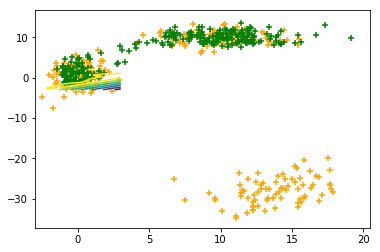

itr: 5000 done
itr: 5050 done
showing a graph


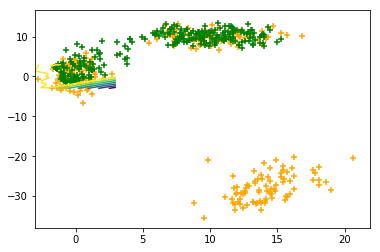

itr: 5100 done
itr: 5150 done
showing a graph


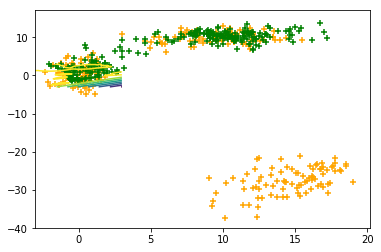

itr: 5200 done
itr: 5250 done
showing a graph


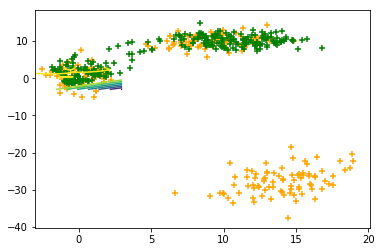

itr: 5300 done
itr: 5350 done
showing a graph


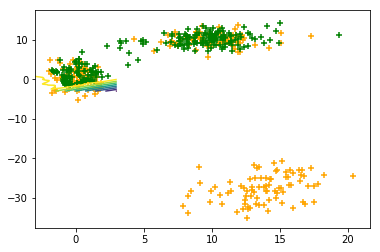

itr: 5400 done
itr: 5450 done
showing a graph


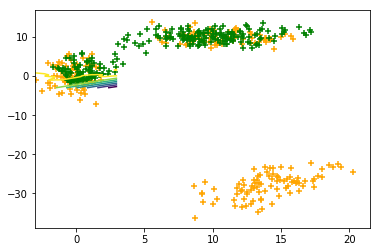

itr: 5500 done
itr: 5550 done
showing a graph


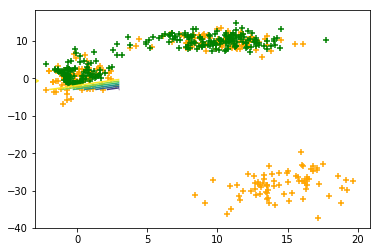

itr: 5600 done
itr: 5650 done
showing a graph


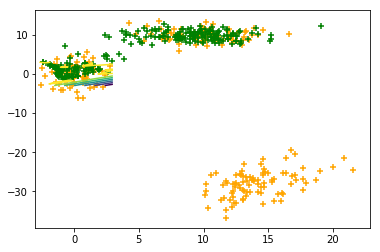

itr: 5700 done
itr: 5750 done
showing a graph


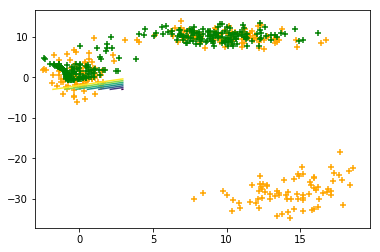

itr: 5800 done
itr: 5850 done
showing a graph


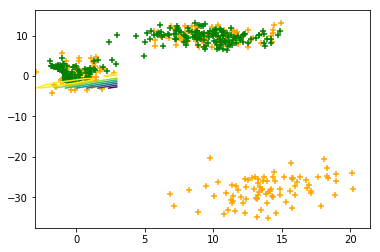

itr: 5900 done
itr: 5950 done
showing a graph


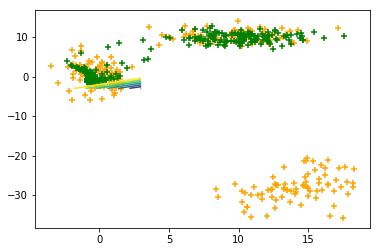

itr: 6000 done
itr: 6050 done
showing a graph


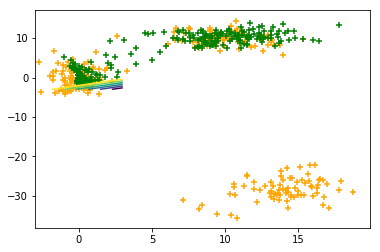

itr: 6100 done
itr: 6150 done
showing a graph


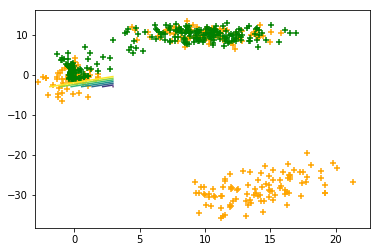

itr: 6200 done
itr: 6250 done
showing a graph


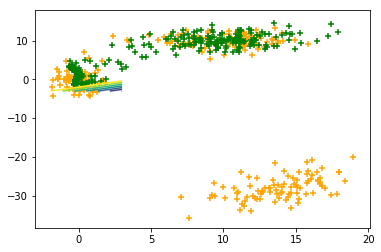

itr: 6300 done
itr: 6350 done
showing a graph


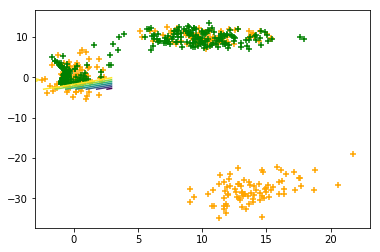

itr: 6400 done
itr: 6450 done
showing a graph


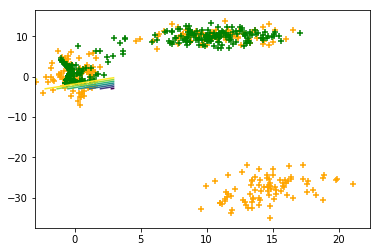

itr: 6500 done
itr: 6550 done
showing a graph


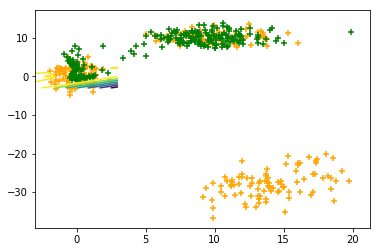

itr: 6600 done
itr: 6650 done
showing a graph


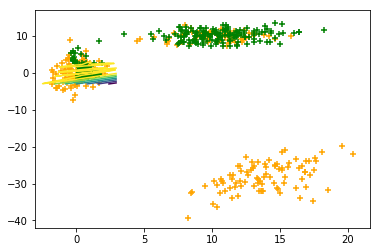

itr: 6700 done
itr: 6750 done
showing a graph


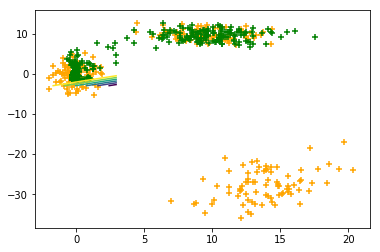

itr: 6800 done
itr: 6850 done
showing a graph


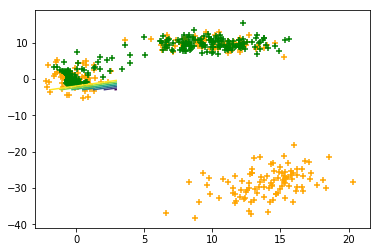

itr: 6900 done
itr: 6950 done
showing a graph


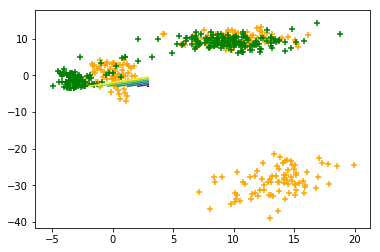

itr: 7000 done
itr: 7050 done
showing a graph


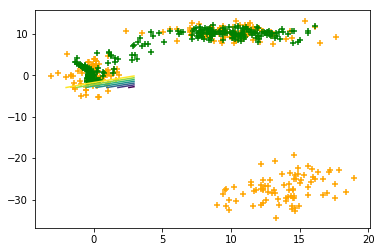

itr: 7100 done
itr: 7150 done
showing a graph


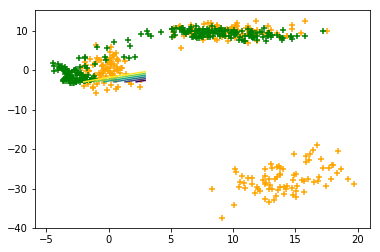

itr: 7200 done
itr: 7250 done
showing a graph


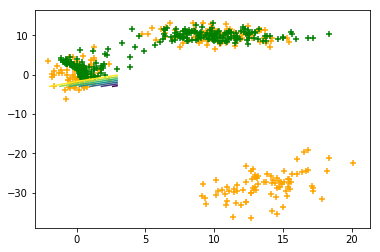

itr: 7300 done
itr: 7350 done
showing a graph


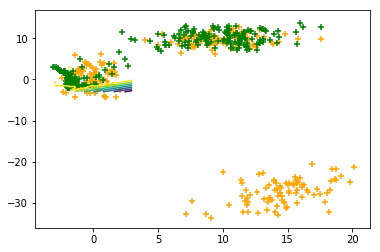

itr: 7400 done
itr: 7450 done
showing a graph


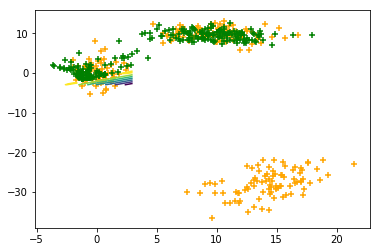

itr: 7500 done
itr: 7550 done
showing a graph


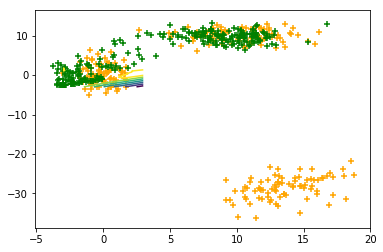

itr: 7600 done
itr: 7650 done
showing a graph


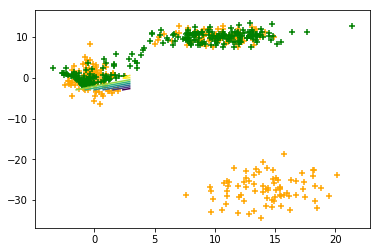

itr: 7700 done


RuntimeError: cuda runtime error (4) : unspecified launch failure at /opt/conda/conda-bld/pytorch_1503970438496/work/torch/lib/THC/generated/../THCReduceAll.cuh:334

In [15]:
## dont touch unless you want to train
for itr in range(10000):
    ## D training and hence layers paprams should get updated.
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update

    for iter_d in range(DISCRI_ITR):
        #print(iter_d)
        _data = next(dtriple)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)
        #print(real_data_v)

        D.zero_grad()

        # train with real
        D_real = D(real_data_v)
        D_real = D_real.mean() + D_real.std()
        D_real.backward(onebar)

        # train with fake
        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise, volatile=True)  # totally freeze netG
        
        #noisev = agd.Variable(noise)
        gop = G(noisev, real_data_v)
        #print('here3')
        fake = agd.Variable(gop.data)
        inputv = fake
        D_fake = D(inputv)
        D_fake = D_fake.mean() + D_fake.std()
        D_fake.backward(one)

        # train with gradient penalty
        gradient_penalty = calc_gp(D, real_data_v.data, fake.data)
        gradient_penalty.backward()

        D_cost = D_fake - D_real + gradient_penalty
        Wasserstein_D = D_real - D_fake
        optD.step()
        #print('discri iter done ', iter_d)

    if not FIXED_GEN:
        #now the discriminator should not be updating it's weights
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()

        _data = next(dtriple)
        real_data = torch.Tensor(_data)
        real_data = real_data.cuda()
        real_data_v = agd.Variable(real_data)

        noise = torch.randn(BATCHSZ, 2)
        noise = noise.cuda()
        noisev = agd.Variable(noise)
        fake = G(noisev, real_data_v)
        g_ = D(fake)
        g_ = g_.mean()
        g_.backward(onebar)
        G_cost = -g_
        optG.step()
    if itr%50 == 0:
        print('itr: {} done'.format(itr))
    # Write logs and save samples
    #lib.plot.plot('tmp/' + DATASET + '/' + 'disc cost', D_cost.cpu().data.numpy())
    #lib.plot.plot('tmp/' + DATASET + '/' + 'wasserstein distance', Wasserstein_D.cpu().data.numpy())
    if not FIXED_GEN:
        #lib.plot.plot('tmp/' + DATASET + '/' + 'gen cost', G_cost.cpu().data.numpy())
        if itr % 100 == 99:
        #lib.plot.flush()
            generate_image(_data)
        #lib.plot.tick()